In [129]:
import pandas as pd
import numpy as np
import datetime
import sklearn
from sklearn.model_selection import TimeSeriesSplit

from collections import Counter
from sklearn.base import BaseEstimator
from tqdm import trange
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
import copy

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline

from xgboost import XGBClassifier

In [166]:
data.TS_indexer

22       2017-11-08
41       2017-11-16
134      2017-11-01
135      2017-11-01
150      2017-11-01
215      2017-11-07
336      2017-11-14
369      2017-11-27
386      2017-11-01
400      2017-11-15
420      2017-11-19
421      2017-11-01
484      2017-11-12
516      2017-11-10
634      2017-11-25
652      2017-11-22
700      2017-11-26
701      2017-11-16
702      2017-11-26
817      2017-11-03
1044     2017-11-10
1144     2017-11-07
1363     2017-11-27
1372     2017-11-07
1396     2017-11-08
1445     2017-11-20
1460     2017-11-27
1618     2017-11-13
1631     2017-11-17
1646     2017-10-30
            ...    
69539    2017-11-11
69544    2017-11-11
69626    2017-11-13
69646    2017-11-14
69647    2017-11-27
69789    2017-11-23
69790    2017-11-23
69791    2017-11-23
69794    2017-11-23
69796    2017-11-23
69964    2017-11-10
70081    2017-11-04
70104    2017-11-08
70110    2017-11-14
70180    2017-11-09
70198    2017-11-23
70206    2017-11-19
70227    2017-11-13
70419    2017-11-12


In [283]:
class forget_model(BaseEstimator):
    def __init__(self, model=LogisticRegression(),n_splits=4, balance=None):
        self._models = [] # лист, в котором будут храниться обученные модели для каждого сплита
        self.n_splits = n_splits # число сплитов
        self.balance = balance # должен поддерживать большинство 
        # методов из imbalanced-learn, которые поддерживают fit_sample
        self.model = model # модели, поддерживающие fit, predict и predict_proba
        self.data = []
    # inputs - уникальные значения дат
    def _iterate_megabatches(self, inputs, n_splits): # делает разбиение по времени без пересечений
        batchsize = len(inputs)//n_splits
        for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
            excerpt = np.arange(start_idx, start_idx + batchsize)
            yield inputs[excerpt]
    
    # X - это весь датафрейм за два месяца ВМЕСТЕ с таргетом
    def fit(self, Z, y):
        if type(Z) == pd.core.frame.DataFrame:
            pass
        else:
            X = pd.DataFrame(Z, columns = np.array(['user_id', 'label', 'amount', 'client_age', 'cat_new_ip',
                                                              'cat_new_prov', 'channel_op', 'op_type', 'recip_age', 'age_diff',
                                                              'cumulative_sum_total', 'data_i_120', 'relative',
                                                              'know_recip_power', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
                                                              'cdf_s_129', 'cdf_s_134', 'data_i_154', 'cdf_s_133',
                                                              'know_recip_card_age', 'recip_card_age', 'one_region', 'krp_pow2',
                                                              'log_amount', 'ip_isp', 'amnt2chnls', 'short_date', 'TS_indexer']))
            X.label = np.array(X.label.values, dtype=int)
            X.TS_indexer = np.array(X.TS_indexer.values, dtype=object)
        models = [] # пустой список моделей
        batch_df_i_neg = pd.DataFrame() # заготовки для не фрода в итом сплите
        batch_df_pos = pd.DataFrame() #  заготовка для фрода
        unique_TS_split = np.array(sorted(X.TS_indexer.unique())) # получаем число уникальных дат
        
        for train_index in self._iterate_megabatches(inputs=unique_TS_split, n_splits=self.n_splits): 
            batch_df_i_old_neg = batch_df_i_neg # сохраняем прошлуб базу не фрода
            batch_df_i = X[X.TS_indexer.isin(train_index)] # получаем базу данных итого сплита
            batch_df_i_pos = batch_df_i[batch_df_i.label==1] #  разбиваем ее на фрод
            batch_df_i_neg = batch_df_i[batch_df_i.label==0] #  и не фрод
            batch_df_pos = pd.concat([batch_df_pos, batch_df_i_pos]) # получаем данные не фрода для обучения
            batch_df_neg = pd.concat([batch_df_i_old_neg, batch_df_i_neg]) # получаем данные фрода для обучения
            df_i = pd.concat([batch_df_pos, batch_df_neg]) #  объединяем фрод и не фрод
            X_df_i = df_i.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1) #  выделяем обучение
            y_df_i = df_i.label #  и таргет
            if self.balance is None: #  без балансировки просто продолжаем
                pass
            else: 
                balancing = self.balance 
                X_df_balanced_i, y_df_balanced_i = balancing.fit_sample(X_df_i.values, y_df_i.values) # делаем перебалансировку
                X_df_i = X_df_balanced_i
                y_df_i = y_df_balanced_i
            self.data.append(df_i)
            model_i = copy.copy(self.model) # итая модель
            model_i.fit(X_df_i.values, y_df_i.values) # обучаем итую модель

            
            models.append(copy.copy(model_i)) #  сохраняем ее в лист
        self._models = copy.copy(models) #  возвращаем в селф


    def predict(self, X_test2):
        if X_test2.shape[1] == 30:                
            if type(X_test2) == pd.core.frame.DataFrame:
                X_test = X_test2
            else:
                X_test = pd.DataFrame(X_test2, columns = np.array(['user_id', 'label', 'amount', 'client_age', 'cat_new_ip',
                                                                  'cat_new_prov', 'channel_op', 'op_type', 'recip_age', 'age_diff',
                                                                  'cumulative_sum_total', 'data_i_120', 'relative',
                                                                  'know_recip_power', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
                                                                  'cdf_s_129', 'cdf_s_134', 'data_i_154', 'cdf_s_133',
                                                                  'know_recip_card_age', 'recip_card_age', 'one_region', 'krp_pow2',
                                                                  'log_amount', 'ip_isp', 'amnt2chnls', 'short_date', 'TS_indexer']))
            X_test = X_test.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1)
        else:
            if type(X_test2) == pd.core.frame.DataFrame:
                X_test = X_test2
            else:
                X_test = pd.DataFrame(X_test2, columns = np.array(['amount', 'client_age', 'cat_new_ip',
                                                                  'cat_new_prov', 'channel_op', 'op_type', 'recip_age', 'age_diff',
                                                                  'cumulative_sum_total', 'data_i_120', 'relative',
                                                                  'know_recip_power', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
                                                                  'cdf_s_129', 'cdf_s_134', 'data_i_154', 'cdf_s_133',
                                                                  'know_recip_card_age', 'recip_card_age', 'one_region', 'krp_pow2',
                                                                  'log_amount', 'ip_isp', 'amnt2chnls']))     
        pr = np.zeros(len(X_test)) # заготовка
        if self.n_splits==1:
            predictions = self._models[0].predict(X_test.values)
        else:
            for model_i in self._models:
                pr_i = model_i.predict(X_test.values) # предсказания итой модели
                pr = np.vstack([pr,pr_i]) # объединяем предсказания
            predictions = np.array([Counter(x).most_common(1)[0][0] for x in pr[1:].T]) #  простое голосвание
        return predictions
    
    def predict_proba(self, X_test2):
        if X_test2.shape[1] == 30:                
            if type(X_test2) == pd.core.frame.DataFrame:
                X_test = X_test2
            else:
                X_test = pd.DataFrame(X_test2, columns = np.array(['user_id', 'label', 'amount', 'client_age', 'cat_new_ip',
                                                                  'cat_new_prov', 'channel_op', 'op_type', 'recip_age', 'age_diff',
                                                                  'cumulative_sum_total', 'data_i_120', 'relative',
                                                                  'know_recip_power', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
                                                                  'cdf_s_129', 'cdf_s_134', 'data_i_154', 'cdf_s_133',
                                                                  'know_recip_card_age', 'recip_card_age', 'one_region', 'krp_pow2',
                                                                  'log_amount', 'ip_isp', 'amnt2chnls', 'short_date', 'TS_indexer']))
            X_test = X_test.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1)
        else:
            if type(X_test2) == pd.core.frame.DataFrame:
                X_test = X_test2
            else:
                X_test = pd.DataFrame(X_test2, columns = np.array(['amount', 'client_age', 'cat_new_ip',
                                                                  'cat_new_prov', 'channel_op', 'op_type', 'recip_age', 'age_diff',
                                                                  'cumulative_sum_total', 'data_i_120', 'relative',
                                                                  'know_recip_power', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
                                                                  'cdf_s_129', 'cdf_s_134', 'data_i_154', 'cdf_s_133',
                                                                  'know_recip_card_age', 'recip_card_age', 'one_region', 'krp_pow2',
                                                                  'log_amount', 'ip_isp', 'amnt2chnls']))

        pr = np.array([np.zeros(len(X_test))]*2).T #заготовка
        if self.n_splits==1:
            predictions = self._models[0].predict_proba(X_test.values)
        else:
            for model_i in self._models:
                pr_i = model_i.predict_proba(X_test.values) #  получаем вероятности итой модели
                pr = np.sum([pr, pr_i], axis = 0) 
            predictions = pr/len(self._models) #  получаем усредненные вероятности
        return predictions


def train_val_ts_split(X, th=0.7, split_target=None): # X - датафрейм, в котором есть  TS_indexer
    unique_TS_split = np.array(sorted(X.TS_indexer.unique()))
    batchsize = int(len(unique_TS_split)*th)
    excerpt_train = np.arange(0, batchsize)
    excerpt_val =  np.arange(batchsize, len(unique_TS_split))
    d_train =  X[X.TS_indexer.isin(unique_TS_split[excerpt_train])]
    d_val = X[X.TS_indexer.isin(unique_TS_split[excerpt_val])]
    if split_target is None:
        return d_train, d_val
    else:
        return d_train.drop('label', axis=1), d_train.label, d_val.drop('label', axis=1), d_val.label

Загружаем данные с фичами.

In [138]:
data = pd.read_csv("../data/coms_sep/train.csv", index_col=0)

data['TS_indexer'] = data.short_date
data.fillna(0, inplace=True)
data.drop(['event_id', 'event_time'], axis = 1, inplace=True)

Разбиваем на трейн и валидацию.

In [284]:
X_train, X_val = train_val_ts_split(data , th=0.7, split_target=None)
y_val = X_val['label'].values
y_train = X_train['label'].values
x_train = X_train.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1)

Трейн разбиваем на фолды для временной кросс-валидации.

In [140]:
unique_TS_split_train = np.array(sorted(X_train.TS_indexer.unique()))

In [143]:
tscv = TimeSeriesSplit(n_splits=3, max_train_size=21)

In [144]:
for train_index, test_index in tscv.split(unique_TS_split_train):
    print("TRAIN LEN:", len(unique_TS_split_train[train_index]), "TEST LEN:", len(unique_TS_split_train[test_index]))

TRAIN LEN: 6 TEST LEN: 5
TRAIN LEN: 11 TEST LEN: 5
TRAIN LEN: 16 TEST LEN: 5


Делаем разбиение для кросс-валидации.

In [145]:
X_train_id = X_train.reset_index(drop=True)

temp_TS_cv = [
    (X_train_id[X_train_id.TS_indexer.isin(unique_TS_split_train[train_index])].index.tolist(), 
     X_train_id[X_train_id.TS_indexer.isin(unique_TS_split_train[test_index])].index.tolist()) for (train_index, test_index) in tscv.split(unique_TS_split_train) if len(train_index)>=2]

completed_TS_cv = [(train, test) for (train, test) in temp_TS_cv if X_train_id.iloc[test].label.sum() >= 1]

In [146]:
len(completed_TS_cv)

3

In [147]:
for i in range(len(completed_TS_cv)):
    print("Train period: " + str(X_train_id.loc[completed_TS_cv[i][0]].short_date.min())+' - '+str(X_train_id.loc[completed_TS_cv[i][0]].short_date.max()))
    print("Test period: " + str(X_train_id.loc[completed_TS_cv[i][1]].short_date.min())+' - '+str(X_train_id.loc[completed_TS_cv[i][1]].short_date.max()))
    print("\r\n")

Train period: 2017-10-30 - 2017-11-04
Test period: 2017-11-05 - 2017-11-09


Train period: 2017-10-30 - 2017-11-09
Test period: 2017-11-10 - 2017-11-14


Train period: 2017-10-30 - 2017-11-14
Test period: 2017-11-15 - 2017-11-19




In [37]:
smotek = SMOTETomek(random_state=42)
xgb = XGBClassifier(n_jobs=10)
smotkxgb = Pipeline([('smt', smotek), ('xgb', xgb)] 
                    ,memory="../data/cashed_gs/" 
                   )

In [38]:
print('Model with grid search')
# 
params={
    'xgb__max_depth': [3, 5, 8], 
    'xgb__subsample': [0.4, 0.6], 
    'xgb__colsample_bytree': [0.5, 0.7], 
    'xgb__n_estimators': [150, 250],
    'xgb__reg_alpha': [0.01, 0.03] 
}

fm = smotkxgb
rs = GridSearchCV(fm,
                  params,
                  cv=completed_TS_cv,
                  scoring="neg_log_loss",
                  n_jobs=10,
                  verbose=2)

Model with grid search


In [39]:
X = X_train_id.drop(['user_id' ,'short_date','TS_indexer', 'label'], axis=1).as_matrix()

In [290]:
rs.fit(X, y_train)
best_est = rs.best_estimator_
print(best_est)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.4 
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.4 
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.4 
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.6 
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.4, total=   1.2s
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.6 
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=150, xgb__reg_alpha=0.03, xgb__subsample=0.4 
[CV] xgb__c

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   26.7s


[CV]  xgb__colsample_bytree=0.5, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.6, total=   6.7s
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.03, xgb__subsample=0.4 
[CV]  xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=250, xgb__reg_alpha=0.03, xgb__subsample=0.4, total=  15.3s
[CV]  xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=250, xgb__reg_alpha=0.01, xgb__subsample=0.6, total=  18.3s
[CV]  xgb__colsample_bytree=0.5, xgb__max_depth=3, xgb__n_estimators=250, xgb__reg_alpha=0.03, xgb__subsample=0.6, total=  13.2s
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.03, xgb__subsample=0.4 
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.03, xgb__subsample=0.6 
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.03, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=

[CV] xgb__colsample_bytree=0.5, xgb__max_depth=8, xgb__n_estimators=250, xgb__reg_alpha=0.01, xgb__subsample=0.6 
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=8, xgb__n_estimators=250, xgb__reg_alpha=0.01, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.5, xgb__max_depth=8, xgb__n_estimators=250, xgb__reg_alpha=0.01, xgb__subsample=0.4, total=  16.5s
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=8, xgb__n_estimators=250, xgb__reg_alpha=0.03, xgb__subsample=0.4 
[CV]  xgb__colsample_bytree=0.5, xgb__max_depth=8, xgb__n_estimators=150, xgb__reg_alpha=0.03, xgb__subsample=0.6, total=  18.8s
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=8, xgb__n_estimators=250, xgb__reg_alpha=0.03, xgb__subsample=0.4 
[CV]  xgb__colsample_bytree=0.5, xgb__max_depth=8, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.6, total=  25.6s
[CV] xgb__colsample_bytree=0.5, xgb__max_depth=8, xgb__n_estimators=250, xgb__reg_alpha=0.03, xgb__subsample=0.4 
[CV]  xgb__colsample_bytree=0.5, xgb__max_d

[CV]  xgb__colsample_bytree=0.7, xgb__max_depth=3, xgb__n_estimators=250, xgb__reg_alpha=0.01, xgb__subsample=0.6, total=  14.6s
[CV] xgb__colsample_bytree=0.7, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.4 
[CV] xgb__colsample_bytree=0.7, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.6 
[CV] xgb__colsample_bytree=0.7, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__max_depth=3, xgb__n_estimators=250, xgb__reg_alpha=0.01, xgb__subsample=0.6, total=  14.8s
[CV] xgb__colsample_bytree=0.7, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__max_depth=3, xgb__n_estimators=250, xgb__reg_alpha=0.03, xgb__subsample=0.6, total=  11.4s
[CV] xgb__colsample_bytree=0.7, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.03, xgb__subsample=0.4 
[CV]  xgb__colsample_bytree=0.5, xgb__max_d

[CV]  xgb__colsample_bytree=0.7, xgb__max_depth=8, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.4, total=  24.5s
[CV] xgb__colsample_bytree=0.7, xgb__max_depth=8, xgb__n_estimators=250, xgb__reg_alpha=0.01, xgb__subsample=0.4 
[CV]  xgb__colsample_bytree=0.7, xgb__max_depth=8, xgb__n_estimators=150, xgb__reg_alpha=0.03, xgb__subsample=0.4, total=  15.9s
[CV] xgb__colsample_bytree=0.7, xgb__max_depth=8, xgb__n_estimators=250, xgb__reg_alpha=0.01, xgb__subsample=0.4 
[CV]  xgb__colsample_bytree=0.7, xgb__max_depth=8, xgb__n_estimators=150, xgb__reg_alpha=0.01, xgb__subsample=0.6, total=  23.8s
[CV] xgb__colsample_bytree=0.7, xgb__max_depth=8, xgb__n_estimators=250, xgb__reg_alpha=0.01, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__max_depth=8, xgb__n_estimators=150, xgb__reg_alpha=0.03, xgb__subsample=0.6, total=  17.8s
[CV]  xgb__colsample_bytree=0.7, xgb__max_depth=8, xgb__n_estimators=150, xgb__reg_alpha=0.03, xgb__subsample=0.4, total=  20.4s
[CV] xgb__col

[Parallel(n_jobs=10)]: Done 144 out of 144 | elapsed:  4.3min finished


Pipeline(memory='../data/cashed_gs/',
     steps=[('smt', SMOTETomek(k=None, kind_smote=None, m=None, n_jobs=None, out_step=None,
      random_state=42, ratio='auto', smote=None, tomek=None)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0...0, reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6))])


In [234]:
print('Model with grid search')
# 
params={
    'model__max_depth': [3, 5, 8], 
    'model__subsample': [0.4, 0.6], 
    'model__colsample_bytree': [0.5, 0.7], 
    'model__n_estimators': [150, 250],
    'model__reg_alpha': [0.01, 0.03], 
    'n_splits': [2, 3,4,5] 
}

model = forget_model(model=XGBClassifier(n_jobs=10))
rs = GridSearchCV(model,
                  params,
                  cv=completed_TS_cv,
                  scoring="neg_log_loss",
                  n_jobs=10,
                  verbose=2)

rs.fit(X_train_id.values, y_train)
best_est = rs.best_estimator_
print(best_est)

Model with grid search
Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


  0%|          | 0/2 [00:00<?, ?it/s]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


 50%|█████     | 1/2 [00:00<00:00,  3.55it/s]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


 50%|█████     | 1/2 [00:00<00:00,  2.23it/s]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 



100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


  0%|          | 0/3 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total=   1.0s
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


  0%|          | 0/3 [00:00<?, ?it/s]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


  0%|          | 0/6 [00:00<?, ?it/s]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


  0%|          | 0/5 [00:00<?, ?it/s]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


  0%|          | 0/4 [00:00<?, ?it/s]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 2/2 [00:20<00:00, 10.34s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total=  21.0s
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 2/2 [00:42<00:00, 21.20s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total=  42.8s
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [01:08<00:00, 22.97s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 1.2min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [01:20<00:00, 26.72s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 1.3min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [01:29<00:00, 29.94s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [00:57<00:00, 28.76s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total=  57.8s
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


 33%|███▎      | 1/3 [00:28<00:57, 28.88s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 2.0min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [00:58<00:00, 29.13s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total=  58.6s
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 2/2 [00:59<00:00, 29.81s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


 83%|████████▎ | 5/6 [02:22<00:28, 28.58s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


  0%|          | 0/4 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [02:47<00:00, 27.99s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 2.8min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


 20%|██        | 1/5 [00:28<01:52, 28.06s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 2.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


 25%|██▌       | 1/4 [00:28<01:24, 28.21s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 2.9min


 17%|█▋        | 1/6 [00:27<02:18, 27.78s/it]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [01:27<00:00, 29.05s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [01:27<00:00, 29.25s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [01:29<00:00, 29.96s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [00:59<00:00, 29.70s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total=  59.7s
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [00:59<00:00, 29.70s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total=  59.8s
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [00:59<00:00, 29.77s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total=  59.9s


[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  4.2min


[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


 33%|███▎      | 1/3 [00:28<00:56, 28.47s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 2.0min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [02:23<00:00, 28.72s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [02:52<00:00, 28.75s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


  0%|          | 0/6 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 2.9min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [02:23<00:00, 28.63s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [02:50<00:00, 28.36s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 2.8min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 5/5 [02:26<00:00, 29.28s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [01:26<00:00, 29.00s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


 17%|█▋        | 1/6 [00:27<02:18, 27.78s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 1.5min


 20%|██        | 1/5 [00:27<01:51, 27.78s/it]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [00:57<00:00, 28.90s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total=  58.0s
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:00<00:00, 30.01s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:00<00:00, 30.39s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 4/4 [01:56<00:00, 29.14s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 2.0min


 33%|███▎      | 1/3 [00:28<00:57, 28.64s/it]

[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [02:23<00:00, 28.79s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 3/3 [01:27<00:00, 29.16s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [02:51<00:00, 28.66s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 2.9min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [02:21<00:00, 28.35s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [02:26<00:00, 29.20s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


 40%|████      | 2/5 [00:57<01:26, 28.86s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 1.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


 50%|█████     | 3/6 [01:26<01:26, 28.83s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


 33%|███▎      | 2/6 [00:56<01:53, 28.42s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 2.9min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 4/4 [01:57<00:00, 29.46s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 2.0min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 5/5 [02:25<00:00, 29.03s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:34<00:00, 47.26s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.6min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [02:53<00:00, 28.96s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 2.9min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [01:36<00:00, 48.44s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.6min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [02:24<00:00, 28.95s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


 67%|██████▋   | 2/3 [01:37<00:48, 48.51s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [02:27<00:00, 29.50s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 2.9min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


  0%|          | 0/5 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 2.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


 20%|██        | 1/5 [00:48<03:12, 48.04s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [02:25<00:00, 48.65s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 2/2 [01:35<00:00, 47.60s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.6min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 3/3 [02:25<00:00, 48.39s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


 50%|█████     | 1/2 [00:47<00:47, 47.49s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


 67%|██████▋   | 4/6 [03:08<01:34, 47.07s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 3.3min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 2/2 [01:38<00:00, 49.26s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.6min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [04:03<00:00, 48.67s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 4.1min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [04:04<00:00, 48.86s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [02:24<00:00, 48.01s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [04:05<00:00, 49.15s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [04:45<00:00, 47.59s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


  0%|          | 0/2 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 4.8min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


 25%|██▌       | 1/4 [00:49<02:27, 49.23s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 4.7min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:29<00:00, 49.90s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:37<00:00, 48.65s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.6min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:38<00:00, 49.06s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.6min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:39<00:00, 49.65s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 4/4 [03:19<00:00, 49.77s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 3.3min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [03:59<00:00, 47.86s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 4.0min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [02:26<00:00, 48.74s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [04:41<00:00, 46.99s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 4.7min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:00<00:00, 48.13s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 4.0min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [02:24<00:00, 48.27s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


 20%|██        | 1/5 [00:46<03:07, 46.84s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


  0%|          | 0/2 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [04:52<00:00, 48.67s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 4.9min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:36<00:00, 48.09s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.6min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:37<00:00, 48.63s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.6min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:42<00:00, 51.08s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


 67%|██████▋   | 2/3 [01:38<00:49, 49.16s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 3.2min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [04:44<00:00, 47.50s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 4.8min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [04:06<00:00, 49.38s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 4.1min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [02:27<00:00, 49.21s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.5min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [04:01<00:00, 48.21s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 4.0min
[CV] model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [04:52<00:00, 48.73s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 4.9min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 5/5 [04:00<00:00, 48.13s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 4.0min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:23<00:00, 47.89s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:26<00:00, 48.77s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:50<00:00, 55.34s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:49<00:00, 54.99s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.8min


 60%|██████    | 3/5 [02:25<01:37, 48.57s/it]

[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 4/4 [03:15<00:00, 48.81s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 3.3min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [01:51<00:00, 55.77s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [03:58<00:00, 47.60s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 4.0min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [04:49<00:00, 48.21s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 4.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [02:37<00:00, 52.45s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.6min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


 25%|██▌       | 1/4 [00:52<02:37, 52.46s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:03<00:00, 48.60s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


 40%|████      | 2/5 [01:42<02:33, 51.23s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 4.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [02:45<00:00, 55.06s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [02:46<00:00, 55.51s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:47<00:00, 53.66s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:52<00:00, 56.26s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 4/4 [03:39<00:00, 54.94s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 3.7min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 2/2 [01:53<00:00, 56.82s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 4.4min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


  0%|          | 0/5 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [05:14<00:00, 52.34s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 5.2min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [02:36<00:00, 52.13s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.6min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [04:26<00:00, 53.27s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 4.4min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [04:36<00:00, 55.39s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 4.6min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


 17%|█▋        | 1/6 [00:48<04:01, 48.25s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.7min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


  0%|          | 0/2 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 5.3min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:49<00:00, 56.64s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:49<00:00, 54.77s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:48<00:00, 54.35s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:54<00:00, 57.10s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 4/4 [03:44<00:00, 56.12s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 3.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [04:28<00:00, 53.79s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [05:11<00:00, 51.86s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 5.2min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [02:41<00:00, 53.94s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.7min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:28<00:00, 53.72s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:34<00:00, 54.97s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 4.6min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [02:43<00:00, 54.49s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.7min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [05:13<00:00, 52.33s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 5.2min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [02:44<00:00, 54.98s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:46<00:00, 53.45s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:53<00:00, 56.61s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


 83%|████████▎ | 5/6 [04:23<00:52, 52.70s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


 33%|███▎      | 1/3 [00:53<01:46, 53.17s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 3.7min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [04:30<00:00, 54.07s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [05:18<00:00, 53.10s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 5.3min


100%|██████████| 3/3 [02:39<00:00, 53.15s/it]


[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


  0%|          | 0/6 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.7min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [04:31<00:00, 54.31s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [05:10<00:00, 51.78s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 5.2min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 5/5 [04:32<00:00, 54.41s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:40<00:00, 53.37s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.7min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:48<00:00, 56.17s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 4/4 [03:46<00:00, 56.68s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 3.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 5/5 [04:27<00:00, 53.46s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [02:56<00:00, 88.03s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 2.9min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [03:00<00:00, 90.04s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.0min


[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 41.4min


[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [03:02<00:00, 91.45s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.1min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [05:11<00:00, 51.98s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 5.2min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:29<00:00, 53.91s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:37<00:00, 55.54s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 4.6min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [05:20<00:00, 53.46s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 5.4min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [04:25<00:00, 88.52s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 4.4min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [04:30<00:00, 90.25s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 2/2 [03:00<00:00, 90.46s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.0min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


  0%|          | 0/3 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 4.5min


 60%|██████    | 3/5 [04:20<02:53, 86.91s/it]

[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:06<00:00, 93.27s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.1min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 4/4 [06:01<00:00, 90.26s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 6.0min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 2/2 [03:12<00:00, 96.10s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [07:20<00:00, 88.09s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 7.4min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [07:19<00:00, 87.87s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 7.3min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [08:29<00:00, 84.89s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 8.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [08:31<00:00, 85.29s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 7.7min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


  0%|          | 0/5 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 4.4min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


  0%|          | 0/2 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 8.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [04:28<00:00, 89.61s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


 40%|████      | 2/5 [02:57<04:25, 88.59s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 4.7min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [02:55<00:00, 87.69s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 2.9min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:00<00:00, 90.12s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.0min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:09<00:00, 94.75s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 4/4 [06:05<00:00, 91.38s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 6.1min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [04:30<00:00, 90.03s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [07:31<00:00, 90.21s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 7.5min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [08:39<00:00, 86.60s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 8.7min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [07:17<00:00, 87.50s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 7.3min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [04:26<00:00, 88.71s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 4.4min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


 50%|█████     | 3/6 [04:17<04:17, 85.81s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 4.5min


 20%|██        | 1/5 [01:23<05:34, 83.65s/it]

[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


 40%|████      | 2/5 [02:52<04:18, 86.20s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 7.6min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [08:35<00:00, 85.95s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 8.6min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [02:56<00:00, 88.21s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 2.9min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


 80%|████████  | 4/5 [05:50<01:27, 87.61s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.0min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:09<00:00, 94.76s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 4/4 [06:12<00:00, 93.06s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 6.2min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [08:44<00:00, 87.48s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 8.8min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 3/3 [04:20<00:00, 86.99s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 4.4min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


 33%|███▎      | 1/3 [01:29<02:58, 89.21s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 7.3min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [07:19<00:00, 87.82s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 7.3min
[CV] model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [07:24<00:00, 88.95s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 7.4min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 6/6 [08:48<00:00, 88.03s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 8.8min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [04:27<00:00, 89.14s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 4.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


 50%|█████     | 3/6 [04:22<04:22, 87.44s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 4.6min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:13<00:00, 96.65s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:24<00:00, 102.19s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.4min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:23<00:00, 101.91s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 6.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


  0%|          | 0/6 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.4min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [07:27<00:00, 89.47s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 7.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


  0%|          | 0/4 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 7.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


 33%|███▎      | 1/3 [01:37<03:14, 97.19s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 8.8min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [04:37<00:00, 92.37s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 4.6min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [08:37<00:00, 86.18s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 8.6min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 5/5 [07:31<00:00, 90.28s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 7.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [04:52<00:00, 97.54s/it]]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 4.9min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [05:07<00:00, 102.49s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 5.1min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:16<00:00, 98.14s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


 60%|██████    | 3/5 [04:46<03:10, 95.45s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.4min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:28<00:00, 104.48s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.5min


100%|██████████| 5/5 [07:48<00:00, 93.72s/it]

[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 



  0%|          | 0/6 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 7.8min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


 80%|████████  | 4/5 [06:29<01:37, 97.38s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 6.7min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [09:16<00:00, 92.80s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 9.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [08:11<00:00, 98.30s/it]]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 8.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [04:46<00:00, 95.49s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 4.8min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [08:12<00:00, 98.46s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 8.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 6/6 [09:15<00:00, 92.53s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 9.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [04:52<00:00, 97.57s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 4.9min


 17%|█▋        | 1/6 [01:19<06:39, 79.99s/it]

[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [05:06<00:00, 102.01s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 5.1min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:11<00:00, 95.64s/it]]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:22<00:00, 101.44s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.4min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:27<00:00, 103.52s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


 60%|██████    | 3/5 [05:00<03:20, 100.24s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 6.8min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [08:01<00:00, 96.24s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 8.0min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [04:40<00:00, 93.53s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 4.7min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [09:06<00:00, 91.06s/it]]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 9.1min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [08:11<00:00, 98.31s/it]]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 8.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [04:52<00:00, 97.34s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 4.9min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 5/5 [08:31<00:00, 102.33s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 8.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [09:16<00:00, 92.79s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 9.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [05:07<00:00, 102.36s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 5.1min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


 40%|████      | 2/5 [03:14<04:52, 97.47s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:26<00:00, 103.20s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.4min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:33<00:00, 106.87s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.6min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 4/4 [06:45<00:00, 101.45s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 6.8min


  0%|          | 0/5 [00:00<?, ?it/s].52s/it]

[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [07:57<00:00, 95.52s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 8.0min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [08:59<00:00, 89.95s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 9.0min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [04:51<00:00, 97.02s/it]]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 4.9min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [07:55<00:00, 95.16s/it]]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 7.9min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [09:04<00:00, 90.73s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 9.1min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [04:52<00:00, 97.46s/it]]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 4.9min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 5/5 [08:25<00:00, 101.07s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 8.4min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [05:10<00:00, 103.54s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 5.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 4/4 [06:45<00:00, 101.45s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 6.8min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [05:11<00:00, 155.68s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 5.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 5/5 [08:00<00:00, 96.11s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 8.0min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [05:27<00:00, 163.51s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 5.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [09:20<00:00, 93.36s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 9.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [05:46<00:00, 173.31s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 8.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


  0%|          | 0/6 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 5.8min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [09:08<00:00, 91.40s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 9.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [08:13<00:00, 98.70s/it]]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 8.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [07:49<00:00, 156.61s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 7.8min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [07:57<00:00, 159.23s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 8.0min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 2/2 [05:15<00:00, 157.78s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 5.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 3/3 [08:19<00:00, 166.56s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 8.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [05:34<00:00, 167.26s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 5.6min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 4/4 [11:14<00:00, 168.72s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total=11.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 2/2 [05:41<00:00, 170.54s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 5.7min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [12:58<00:00, 155.71s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total=13.0min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [14:35<00:00, 145.95s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total=14.6min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [13:23<00:00, 160.72s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total=13.4min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [13:31<00:00, 162.28s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total=13.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [07:39<00:00, 153.13s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 7.7min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [08:02<00:00, 160.75s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 8.0min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


 25%|██▌       | 1/4 [02:36<07:50, 156.98s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total=15.0min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [08:35<00:00, 171.94s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 8.6min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [05:14<00:00, 157.14s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 5.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [05:28<00:00, 164.40s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 5.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [05:46<00:00, 173.10s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 5.8min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 4/4 [11:04<00:00, 166.04s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total=11.1min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [13:08<00:00, 157.75s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total=13.2min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [07:47<00:00, 155.84s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 7.8min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [15:19<00:00, 153.22s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total=15.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [13:26<00:00, 161.28s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total=13.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [07:59<00:00, 159.98s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 8.0min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 5/5 [13:33<00:00, 162.76s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total=13.6min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [14:52<00:00, 148.83s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total=14.9min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [08:16<00:00, 165.50s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 8.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [05:16<00:00, 158.31s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 5.3min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [05:26<00:00, 163.32s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 5.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [05:43<00:00, 171.76s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 5.7min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 4/4 [11:03<00:00, 166.00s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total=11.1min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [15:06<00:00, 151.16s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total=15.1min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 3/3 [07:44<00:00, 154.76s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 7.7min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [13:04<00:00, 156.92s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total=13.1min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [13:27<00:00, 161.51s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total=13.5min
[CV] model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [14:59<00:00, 149.90s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total=15.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [07:59<00:00, 159.86s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 8.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 2/2 [01:00<00:00, 30.13s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 5/5 [14:01<00:00, 168.22s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total=14.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 3/3 [08:22<00:00, 167.46s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 8.4min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:00<00:00, 30.09s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:01<00:00, 30.93s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [01:29<00:00, 29.84s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [01:28<00:00, 29.50s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [01:28<00:00, 29.58s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 4/4 [01:59<00:00, 30.00s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 2.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [02:57<00:00, 29.54s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 3.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


 67%|██████▋   | 4/6 [01:55<00:57, 28.80s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 2.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [02:53<00:00, 28.95s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 2.9min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 2/2 [01:00<00:00, 30.20s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 2/2 [01:00<00:00, 30.02s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:02<00:00, 31.44s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.1min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 5/5 [02:27<00:00, 29.41s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 2.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 5/5 [02:31<00:00, 30.26s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 2.5min


100%|██████████| 4/4 [11:22<00:00, 170.63s/it]


[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


  0%|          | 0/6 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total=11.4min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 3/3 [01:27<00:00, 29.05s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 3/3 [01:29<00:00, 29.82s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


  0%|          | 0/6 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total=13.2min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [01:29<00:00, 29.72s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


 50%|█████     | 3/6 [01:28<01:28, 29.43s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total=14.9min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


 83%|████████▎ | 5/6 [02:27<00:29, 29.46s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total=13.2min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 2/2 [00:59<00:00, 29.71s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total=  59.7s
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 5/5 [02:28<00:00, 29.72s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 2.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


 50%|█████     | 1/2 [00:29<00:29, 29.49s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 3.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 4/4 [01:59<00:00, 29.82s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 2.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [00:58<00:00, 29.39s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total=  59.1s


 33%|███▎      | 1/3 [00:29<00:58, 29.27s/it]

[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [01:00<00:00, 30.31s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [02:27<00:00, 29.44s/it]


[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total=14.9min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


  0%|          | 0/4 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 2.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [02:29<00:00, 29.92s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 2.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [01:29<00:00, 29.74s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [02:56<00:00, 29.34s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 2.9min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


 40%|████      | 2/5 [00:58<01:27, 29.10s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [01:29<00:00, 29.70s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


 75%|███████▌  | 3/4 [01:29<00:29, 29.68s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:01<00:00, 30.90s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:00<00:00, 30.26s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 4/4 [01:59<00:00, 29.78s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 2.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [02:25<00:00, 29.17s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 2.4min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


 80%|████████  | 4/5 [02:01<00:30, 30.39s/it]

[CV]  model__colsample_bytree=0.5, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total=13.8min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [02:53<00:00, 28.87s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 2.9min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [02:27<00:00, 29.40s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 2.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


 25%|██▌       | 1/4 [00:29<01:29, 29.67s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 2.6min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


 67%|██████▋   | 2/3 [00:59<00:29, 29.54s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 2.9min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [01:29<00:00, 29.73s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [01:30<00:00, 30.21s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 1.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [01:29<00:00, 29.96s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 1.5min


 50%|█████     | 3/6 [01:25<01:25, 28.56s/it]

[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 4/4 [02:02<00:00, 30.60s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 2.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:36<00:00, 48.47s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.6min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 5/5 [02:25<00:00, 29.19s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 2.4min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [01:41<00:00, 50.64s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [02:52<00:00, 28.75s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 2.9min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


 83%|████████▎ | 5/6 [02:25<00:29, 29.08s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


 67%|██████▋   | 2/3 [01:36<00:48, 48.39s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 2.4min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [02:31<00:00, 30.39s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 2.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [02:54<00:00, 29.06s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 2.9min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [02:25<00:00, 48.49s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [02:31<00:00, 50.45s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [02:28<00:00, 49.39s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.5min


 50%|█████     | 3/6 [02:23<02:23, 47.88s/it]

[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:38<00:00, 49.06s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.6min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:39<00:00, 49.92s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 4/4 [03:18<00:00, 49.62s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 3.3min


[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 160.0min


[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


 83%|████████▎ | 5/6 [04:01<00:48, 48.25s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [04:09<00:00, 49.88s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 4.2min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [04:03<00:00, 48.66s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [04:49<00:00, 48.29s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


  0%|          | 0/5 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 4.8min


 20%|██        | 1/5 [00:49<03:17, 49.28s/it]

[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [02:28<00:00, 49.40s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.5min
[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 4.2min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


  0%|          | 0/2 [00:00<?, ?it/s]

[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 6/6 [04:54<00:00, 49.06s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 4.9min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:30<00:00, 50.05s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.5min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:38<00:00, 49.38s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:41<00:00, 50.74s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:43<00:00, 51.90s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


 83%|████████▎ | 5/6 [04:00<00:48, 48.08s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 3.4min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [02:22<00:00, 47.54s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [04:08<00:00, 49.80s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 4.2min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


 67%|██████▋   | 2/3 [01:42<00:51, 51.18s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:02<00:00, 48.53s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:07<00:00, 49.47s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [02:25<00:00, 48.62s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


 40%|████      | 2/5 [01:39<02:28, 49.59s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.6min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [04:48<00:00, 48.09s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:38<00:00, 49.46s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:39<00:00, 49.58s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:43<00:00, 51.86s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.7min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 4/4 [03:18<00:00, 49.59s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 3.3min


 83%|████████▎ | 5/6 [04:07<00:49, 49.53s/it]

[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 3/3 [02:25<00:00, 48.59s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.4min


100%|██████████| 5/5 [04:09<00:00, 49.90s/it]

[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 



  0%|          | 0/4 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 4.2min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [04:57<00:00, 49.54s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 5.0min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [04:02<00:00, 48.58s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [04:04<00:00, 48.93s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:26<00:00, 48.76s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.4min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 6/6 [04:58<00:00, 49.77s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 5.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:29<00:00, 49.91s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.5min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:52<00:00, 56.33s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:55<00:00, 57.80s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 4/4 [03:18<00:00, 49.69s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 3.3min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [04:04<00:00, 48.89s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 2.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


  0%|          | 0/5 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 4.1min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [04:57<00:00, 49.62s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 5.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [02:47<00:00, 55.78s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


 20%|██        | 1/5 [00:55<03:40, 55.11s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 4.2min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:06<00:00, 49.35s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 4.1min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [04:55<00:00, 49.26s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=3, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 4.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


 50%|█████     | 1/2 [00:58<00:58, 58.70s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [02:51<00:00, 57.27s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 2.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:53<00:00, 56.69s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:58<00:00, 59.40s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 2.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


 60%|██████    | 3/5 [02:53<01:55, 57.69s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 3.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


 67%|██████▋   | 2/3 [01:47<00:53, 53.79s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 2.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [04:46<00:00, 57.40s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [05:24<00:00, 54.16s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 5.4min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [02:44<00:00, 54.78s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [04:39<00:00, 55.82s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 4.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [04:52<00:00, 58.54s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 4.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:48<00:00, 56.23s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 6/6 [05:31<00:00, 55.22s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 5.5min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:59<00:00, 59.69s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 3.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:53<00:00, 56.88s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:55<00:00, 57.75s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 1.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [01:59<00:00, 59.51s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 2.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 4/4 [03:55<00:00, 58.82s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 3.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [04:37<00:00, 55.41s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 4.6min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [05:24<00:00, 54.01s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 5.4min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [02:48<00:00, 56.04s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:39<00:00, 55.83s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 4.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:45<00:00, 57.13s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [05:21<00:00, 53.51s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


  0%|          | 0/2 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 5.4min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


 33%|███▎      | 2/6 [01:42<03:24, 51.21s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 2.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:50<00:00, 55.24s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 1.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [01:58<00:00, 59.42s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 2.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


  0%|          | 0/3 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 2.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 4/4 [03:48<00:00, 57.21s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 3.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [04:47<00:00, 57.59s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 3/3 [02:47<00:00, 55.94s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [05:31<00:00, 55.21s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 5.5min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [04:46<00:00, 57.40s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [05:19<00:00, 53.26s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 5.3min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 5/5 [04:45<00:00, 57.09s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:48<00:00, 56.25s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 2.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [02:59<00:00, 59.76s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 3.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 4/4 [03:59<00:00, 59.85s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 4.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 5/5 [04:37<00:00, 55.57s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 4.6min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:05<00:00, 92.72s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.1min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [03:08<00:00, 94.48s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [05:27<00:00, 54.53s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 5.5min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [03:11<00:00, 95.98s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [04:46<00:00, 57.38s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


 17%|█▋        | 1/6 [01:23<06:59, 83.91s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 5.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [05:27<00:00, 54.59s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 5.5min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [04:43<00:00, 94.34s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 4.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 2/2 [03:04<00:00, 92.44s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.1min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [04:45<00:00, 95.02s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 3/3 [04:45<00:00, 95.28s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:12<00:00, 96.24s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 4/4 [06:18<00:00, 94.70s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 6.3min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 2/2 [03:13<00:00, 96.67s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [07:41<00:00, 92.23s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 7.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [07:50<00:00, 94.15s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 7.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [08:56<00:00, 89.46s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 9.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


 20%|██        | 1/5 [01:28<05:55, 88.90s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 4.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


  0%|          | 0/5 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 4.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 6/6 [08:57<00:00, 89.54s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 8.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


  0%|          | 0/2 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 9.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [04:51<00:00, 97.03s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 4.9min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:04<00:00, 92.29s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.1min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


 67%|██████▋   | 4/6 [05:56<02:58, 89.02s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:15<00:00, 97.78s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.3min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 4/4 [06:19<00:00, 94.91s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 6.3min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [04:40<00:00, 93.49s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 4.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [07:38<00:00, 91.76s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 7.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [08:59<00:00, 89.84s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 9.0min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [07:39<00:00, 91.94s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 7.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [04:38<00:00, 93.00s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 4.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


 40%|████      | 2/5 [02:58<04:27, 89.30s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 8.1min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [04:46<00:00, 95.40s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 4.8min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [09:16<00:00, 92.77s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 9.3min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


 75%|███████▌  | 3/4 [04:48<01:36, 96.01s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.1min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:12<00:00, 96.40s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:12<00:00, 96.47s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.2min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


 80%|████████  | 4/5 [06:05<01:31, 91.41s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 9.1min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 4/4 [06:27<00:00, 96.78s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 6.5min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [07:39<00:00, 91.87s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 7.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [04:37<00:00, 92.45s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 4.6min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


 20%|██        | 1/5 [01:32<06:11, 92.79s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 7.7min
[CV] model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [07:47<00:00, 93.57s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 7.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 6/6 [08:56<00:00, 89.46s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 9.0min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [04:38<00:00, 92.73s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 4.6min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [04:53<00:00, 97.97s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 4.9min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:25<00:00, 102.77s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:38<00:00, 109.13s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.6min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 4/4 [06:24<00:00, 96.19s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 6.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [03:47<00:00, 113.84s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 3.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


 80%|████████  | 4/5 [06:15<01:33, 93.82s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 7.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


 17%|█▋        | 1/6 [01:22<06:53, 82.79s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 9.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [07:48<00:00, 93.62s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 7.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [05:13<00:00, 104.58s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 5.2min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [09:01<00:00, 90.19s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 9.0min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 5/5 [07:50<00:00, 94.19s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=5, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 7.9min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [05:18<00:00, 106.03s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 5.3min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [05:25<00:00, 108.63s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 5.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:30<00:00, 105.28s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.5min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:42<00:00, 111.27s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.7min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:50<00:00, 115.24s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 3.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 4/4 [07:27<00:00, 111.78s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 7.5min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [08:38<00:00, 103.76s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 8.7min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [09:48<00:00, 98.02s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total= 9.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [05:08<00:00, 102.78s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 5.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [08:44<00:00, 104.94s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 8.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [09:39<00:00, 96.50s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 9.7min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 5/5 [09:11<00:00, 110.21s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 5.3min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


  0%|          | 0/2 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total= 9.2min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [05:36<00:00, 112.02s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 5.6min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


 40%|████      | 2/5 [03:38<05:27, 109.06s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.5min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:40<00:00, 110.42s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.7min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [03:49<00:00, 114.73s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 3.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 4/4 [07:23<00:00, 110.81s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 7.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [05:03<00:00, 101.08s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 5.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [08:55<00:00, 107.18s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 8.9min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


 33%|███▎      | 2/6 [02:56<05:53, 88.34s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total= 9.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [08:39<00:00, 103.93s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 8.7min


 25%|██▌       | 1/4 [01:42<05:08, 102.87s/it]

[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [10:04<00:00, 100.70s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 5.3min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


  0%|          | 0/2 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total=10.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 5/5 [09:20<00:00, 112.15s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total= 9.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [05:30<00:00, 110.09s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 5.5min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:30<00:00, 105.06s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.5min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:43<00:00, 111.64s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.7min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [03:52<00:00, 116.48s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 3.9min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 4/4 [07:23<00:00, 110.89s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 7.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [08:34<00:00, 102.80s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 8.6min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [09:48<00:00, 98.03s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total= 9.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [05:04<00:00, 101.59s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 5.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [08:38<00:00, 103.66s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 8.6min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [09:51<00:00, 98.64s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 9.9min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 5/5 [08:55<00:00, 107.12s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total= 8.9min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [05:20<00:00, 107.00s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 5.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [05:42<00:00, 114.25s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 5.7min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 4/4 [07:21<00:00, 110.33s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 7.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [05:47<00:00, 173.85s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 5.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3 


100%|██████████| 5/5 [08:43<00:00, 104.76s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 8.7min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 2/2 [05:53<00:00, 176.76s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 5.9min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 6/6 [10:05<00:00, 100.88s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total=10.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [08:46<00:00, 105.37s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 8.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 2/2 [06:11<00:00, 185.57s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=2, total= 6.2min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [10:05<00:00, 100.91s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total=10.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [09:02<00:00, 108.51s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=150, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 9.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [08:25<00:00, 168.55s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 8.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [08:39<00:00, 173.22s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 8.7min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2 


100%|██████████| 2/2 [05:44<00:00, 172.06s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 5.7min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 3/3 [09:04<00:00, 181.40s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=3, total= 9.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [06:03<00:00, 181.96s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 6.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3 


100%|██████████| 4/4 [12:18<00:00, 184.53s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total=12.3min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


 67%|██████▋   | 2/3 [05:21<02:40, 160.74s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=2, total= 6.2min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [14:01<00:00, 168.28s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total=14.0min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [15:34<00:00, 155.69s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=4, total=15.6min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


  0%|          | 0/6 [00:00<?, ?it/s]

[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total=14.2min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [08:12<00:00, 164.25s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 8.2min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [15:37<00:00, 156.28s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total=15.6min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 5/5 [15:05<00:00, 181.14s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.4, n_splits=5, total=15.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [08:55<00:00, 178.46s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 8.9min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2 


100%|██████████| 3/3 [09:20<00:00, 186.87s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=3, total= 9.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [05:37<00:00, 168.59s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 5.6min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [06:07<00:00, 183.57s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 6.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3 


100%|██████████| 2/2 [06:22<00:00, 191.20s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=2, total= 6.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 4/4 [11:59<00:00, 179.81s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total=12.0min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 5/5 [14:05<00:00, 169.12s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total=14.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4 


100%|██████████| 3/3 [08:28<00:00, 169.46s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 8.5min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 6/6 [16:21<00:00, 163.52s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=4, total=16.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 5/5 [14:09<00:00, 169.88s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total=14.2min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5 


100%|██████████| 3/3 [08:37<00:00, 172.51s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 8.6min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 6/6 [15:48<00:00, 158.08s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total=15.8min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 5/5 [14:51<00:00, 178.24s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.01, model__subsample=0.6, n_splits=5, total=14.9min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2 


100%|██████████| 3/3 [09:17<00:00, 185.97s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=3, total= 9.3min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [05:40<00:00, 170.50s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 5.7min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [05:56<00:00, 178.17s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 5.9min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3 


100%|██████████| 2/2 [06:15<00:00, 187.83s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=2, total= 6.3min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 4/4 [12:02<00:00, 180.64s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total=12.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 6/6 [16:05<00:00, 160.92s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total=16.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4 


100%|██████████| 5/5 [14:06<00:00, 169.25s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=4, total=14.1min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 3/3 [08:33<00:00, 171.15s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 8.6min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 5/5 [14:24<00:00, 172.95s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total=14.4min
[CV] model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5 


100%|██████████| 6/6 [16:00<00:00, 160.00s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total=16.0min


100%|██████████| 5/5 [14:44<00:00, 176.84s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.4, n_splits=5, total=14.8min


100%|██████████| 3/3 [08:16<00:00, 165.36s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 8.3min


100%|██████████| 3/3 [07:57<00:00, 159.10s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=3, total= 8.0min


100%|██████████| 6/6 [08:12<00:00, 82.16s/it]]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 8.2min


100%|██████████| 5/5 [06:05<00:00, 73.11s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 6.1min


100%|██████████| 6/6 [05:31<00:00, 55.19s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 5.5min
[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=4, total= 5.7min


 80%|████████  | 4/5 [02:12<00:33, 33.17s/it]

[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 5.1min


100%|██████████| 5/5 [02:14<00:00, 26.97s/it]


[CV]  model__colsample_bytree=0.7, model__max_depth=8, model__n_estimators=250, model__reg_alpha=0.03, model__subsample=0.6, n_splits=5, total= 2.3min


[Parallel(n_jobs=10)]: Done 576 out of 576 | elapsed: 297.7min finished
100%|██████████| 2/2 [00:03<00:00,  1.58s/it]

forget_model(balance=None,
       model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=10, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       n_splits=2)


Проверка качества модели на валидации:

In [261]:
best_est.model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 150,
 'n_jobs': 10,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0.01,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 0.6}

In [291]:
 best_est.named_steps.xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 8,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 150,
 'n_jobs': 10,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0.01,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 0.6}

In [288]:
#forg_m = best_est.named_steps.xgb
forg_m = forget_model(model=XGBClassifier(), n_splits=1)
forg_m.fit(X_train_id.values, y_train)

100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


In [289]:
preds_proba = forg_m.predict_proba(X_val)
preds = forg_m.predict(X_val)

/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


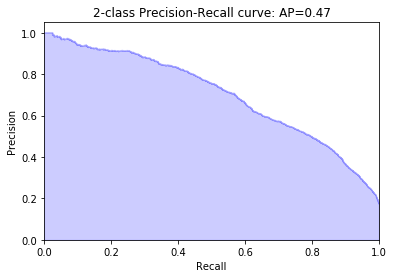

0.7039903901884286

In [290]:
average_precision = average_precision_score(y_val, preds)
precision, recall, thresholds = precision_recall_curve(y_val, preds_proba[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

metrics.auc(recall, precision)

In [241]:
import shap

In [293]:
fraud_ind = np.argmin(y_val)
non_fr = np.argmax(y_val)

explainer = shap.KernelExplainer(best_est.predict_proba,
                                 X_train,
                                 link="logit"
                                )

shap_values = explainer.shap_values(X_val.iloc[[fraud_ind, non_fr], :], nsamples=100)

  0%|          | 0/2 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [271]:
X_val.iloc[[fraud_ind, non_fr], :]

,user_id,label,amount,client_age,cat_new_ip,cat_new_prov,channel_op,op_type,recip_age,age_diff,...,cdf_s_133,know_recip_card_age,recip_card_age,one_region,krp_pow2,log_amount,ip_isp,amnt2chnls,short_date,TS_indexer
369,10544946,0,70000.0,55.547222,2,2,2,0,0,24.547222,...,0,1,237,1,0,11.156265,40.0,0.499996,2017-11-27,2017-11-27
5481,14176218,1,7878.0,63.280556,1,1,2,1,1,-936.719444,...,0,1,912321,0,0,8.971956,44.0,0.009804,2017-11-21,2017-11-21


In [363]:
shap.force_plot(shap_values[0][0,:],
                X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).iloc[[fraud_ind], :],
                link="logit")

In [365]:
shap.force_plot(shap_values[1][0,:],
                X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).iloc[[non_fr], :],
                link="logit")